In [23]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Deepagent for Software Development

We will use the `deepagents` package to create a software developer agent. When using the `deepagents` package, it's important to: 

1. Understand the native tools available
2. Supply task-specific tools
3. Supply task-specific instructions
4. Supply task-specific sub-agents, if necessary

You can see an overview of the native tools in the [deepagents package README](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#model) as well as the [quickstarts README](https://github.com/langchain-ai/deepagents-quickstarts). We'll extend this with two task-specific tools. 

## Task-Specific Tools 

Between the tools built in to the `deepagents` package and the LLM's internal knowledge of coding, we would have a very useful agent without any additional tools. However, we want our code to reflect the latest and greatest libraries, developer tools, and best practices, so let's give our agent access to the internet so it can do some research as it does its work. 



### Search Tool 

There are many different search tools that we can use. For this example, we'll use [Tavily](https://www.tavily.com/) to search the web for helpful content. 

### Fetch Webpage Content Tool

We'll add a tool to fetch content from any webpage, including one we found via the search tool, and return it to our agent in a well-formatted markdown block. 

In [31]:
from developer_agent.tools import tavily_search, fetch_webpage_content

tools = [tavily_search, fetch_webpage_content]

## Filesystem Access

By the default, the agent will use LangGraph's built in short-term memory as a temporary file system. Let's instead give our agent access to a real directory on our computer, so it can write its output code to place where we can find it.  

We will give the agent a file system in "virtual mode", so from our agent's perspective, the entire file system is inside that directory - we're creating a very basic sandbox on our machine!

In [32]:
import os 

WORKSPACE_DIR = "agent_workspace"

# Create a workspace directory
if not os.path.exists(WORKSPACE_DIR):
    os.makedirs(WORKSPACE_DIR)

In [33]:
from deepagents.backends import FilesystemBackend

back_end = FilesystemBackend(
        root_dir=WORKSPACE_DIR,
        virtual_mode=True)

## Task-Specfic Instructions

Let's define a system prompt to tell our deep agent how to use apply itself to the task at hand:

1. Begin by assigning the agent a role
2. Deepagents comes with built-in subagent creation and management, but we'll add some details about how to effectively use subagents for coding tasks.
3. Likewise, we'll add some details about how to use the built-in tools along with the ones we've added. 

In [45]:
from utils import show_prompt, format_messages
from developer_agent.prompts import DEVELOPER_SYSTEM_PROMPT

show_prompt(DEVELOPER_SYSTEM_PROMPT)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  You are an AI assistant that helps users by building applications for them.                                    │
│                                                                                                                 │
│                                                                                                                 │
│  ## Working with Subagents (task tool)                                                                          │
│  When delegating to subagents:                                                                                  │
│  - **Use filesystem for large I/O**: If input instructions are large (>500 words) OR expected output is large,  │
│  communicate via files                                                                                          │
│    - Write input context/instructions to a file, tell subagent to read it                                       │
│    - Ask subagent to write their output to a file, then read it after they return                               │
│    - This prevents token bloat and keeps context manageable in both directions                                  │
│  - **Parallelize independent work**: When tasks are independent, spawn parallel subagents to work               │
│  simultaneously                                                                                                 │
│  - **Clear specifications**: Tell subagent exactly what format/structure you need in their response or output   │
│  file                                                                                                           │
│  - **Main agent synthesizes**: Subagents gather/execute, main agent integrates results into final deliverable   │
│                                                                                                                 │
│  ## Tools                                                                                                       │
│                                                                                                                 │
│  ### File Tools                                                                                                 │
│  - read_file: Read file contents (use absolute paths)                                                           │
│  - edit_file: Replace exact strings in files (must read first, provide unique old_string)                       │
│  - write_file: Create or overwrite files                                                                        │
│  - ls: List directory contents                                                                                  │
│  - glob: Find files by pattern (e.g., "**/*.py")                                                                │
│  - grep: Search file contents                                                                                   │
│                                                                                                                 │
│  Always use absolute paths starting with /.                                                                     │
│                                                                                                                 │
│  ### web_search                                                                                                 │
│  Search for documentation, error solutions, and code examples.                                                  │
│                                                                                                                 │
│  ### fetch_webpage_content                            

## Putting it all together

Let's create our agent and try it out on a basic use case.

In [46]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from deepagents import create_deep_agent

# Model Claude 4.5 - or you can use any you like
model = init_chat_model(model="anthropic:claude-sonnet-4-5-20250929", temperature=0.0)

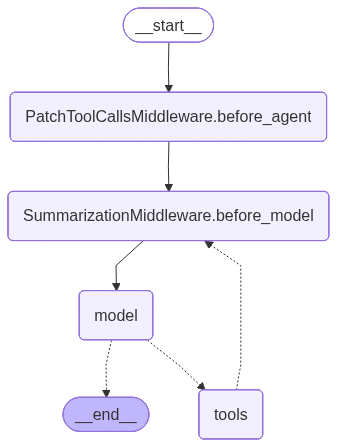

In [47]:
# Create the agent
agent = create_deep_agent(
      model=model,
      tools=tools, 
      system_prompt=DEVELOPER_SYSTEM_PROMPT
  )
  
# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

### Basic Test

Let's see how our agent does when we ask it to write a simple script.

In [48]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Write a fizzbuzz script to a file called `fizzbuz.py`",
            }
        ],
    }, 
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Write a fizzbuzz script to a file called `fizzbuz.py`                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll write a fizzbuzz script to a file called `fizzbuz.py`.                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/fizzbuz.py",                                                                                   │
│   "content": "#!/usr/bin/env python3\n\"\"\"\nFizzBuzz implementation\nPrints numbers from 1 to 100, but:\n-    │
│ For multiples of 3, print \"Fizz\"\n- For multiples of 5, print \"Buzz\"\n- For multiples of both 3 and 5,      │
│ print \"FizzBuzz\"\n\"\"\"\n\ndef fizzbuzz(n=100):\n    \"\"\"\n    Print FizzBuzz sequence from 1 to n\n    \n │
│ Args:\n        n: The upper limit (inclusive) for the sequence\n    \"\"\"\n    for i in range(1, n + 1):\n     │
│ if i % 3 == 0 and i % 5 == 0:\n            print(\"FizzBuzz\")\n        elif i % 3 == 0:\n                      │
│ print(\"Fizz\")\n        elif i % 5 == 0:\n            print(\"Buzz\")\n        else:\n                         │
│ print(i)\n\nif __name__ == \"__main__\":\n    fizzbuzz()\n"                                                     │
│ }                                                                                                               │
│    ID: toolu_01KDed9S9LQqFiyVM347Vyem                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /fizzbuz.py                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Done! I've created the `fizzbuz.py` file with a complete FizzBuzz implementation. The script:                   │
│                                                                                                                 │
│ - Prints numbers from 1 to 100                                                                                  │
│ - Prints "Fizz" for multiples of 3                                                                              │
│ - Prints "Buzz" for multiples of 5                                                                              │
│ - Prints "FizzBuzz" for multiples of both 3 and 5                                                               │
│ - Includes a reusable `fizzbuzz()` function that accepts a parameter for the upper limit                        │
│                                                                                                                 │
│ You can run it with: `python /fizzbuz.py`                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Great - remember that we gave our agent a single directory on our computer as its workspace, so let's take a look there to check out the code!

In [49]:
print(os.listdir('agent_workspace'))

['frontend', 'fizzbuzz.py', 'QUICKSTART.md', 'backend', '__pycache__', 'README.md']


In [50]:
with open('agent_workspace/fizzbuzz.py', 'r') as f:
    contents = f.read()

print(contents)

#!/usr/bin/env python3
"""
FizzBuzz: Print numbers from 1 to 100, but:
- Print "Fizz" for multiples of 3
- Print "Buzz" for multiples of 5
- Print "FizzBuzz" for multiples of both 3 and 5
"""

def fizzbuzz(n=100):
    """
    Print FizzBuzz sequence from 1 to n.
    
    Args:
        n: The upper limit (default: 100)
    """
    for i in range(1, n + 1):
        if i % 3 == 0 and i % 5 == 0:
            print("FizzBuzz")
        elif i % 3 == 0:
            print("Fizz")
        elif i % 5 == 0:
            print("Buzz")
        else:
            print(i)

if __name__ == "__main__":
    fizzbuzz()



## Advanced Use Case

Now, let's see what happens if we ask the the agent to write an entire application with a front end and back end. We're not going to wait for the agent to actually write the code - since we know that the deepagents package is designed to first create a to-do list before starting complex projects, we can interrupt the graph after the first tool call completes to inspect the agent's plan before it executes on it. 

In [52]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": """
                    Write an app with a FastAPI back end that checks the weather, and a React front end to allow 
                    the user to look up the weather for a given location.""",
            }
        ],
    }
    # Remove this line if you want the agent to actually write the application
    interrupt_after=["tools"]
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│                                                                                                                 │
│                     Write an app with a FastAPI back end that checks the weather, and a React front end to      │
│ allow                                                                                                           │
│                     the user to look up the weather for a given location.                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you build a weather app with a FastAPI backend and React frontend. Let me break this down into        │
│ manageable steps.                                                                                               │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research weather API options and set up project structure",                                   │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Create FastAPI backend with weather endpoint",                                                │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Create React frontend with weather lookup interface",                                         │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Create configuration files (requirements.txt, package.json, README)",                         │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_013ZnN9puayv7Mvaxz28NLKc                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research weather API options and set up project structure', 'status':        │
│ 'in_progress'}, {'content': 'Create FastAPI backend with weather endpoint', 'status': 'pending'}, {'content':   │
│ 'Create React frontend with weather lookup interface', 'status': 'pending'}, {'content': 'Create configuration  │
│ files (requirements.txt, package.json, README)', 'status': 'pending'}]                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯